# Load images with tf.data

- This tutorial provides a simple example of how to load an image dataset using [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data).

- The dataset used in this example is distributed as directories of images, with one class of image per directory.

## Setup

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
tf.enable_eager_execution()
tf.VERSION

'1.13.1'

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Download and inspect the dataset

### Retrieve the images

- Before you start any training, you'll need a set of images to teach the network about the new classes you wan to recognize. We've create an archive of creative-commons licensed flower photos to use initially.

In [3]:
import pathlib
data_root = tf.keras.utils.get_file('flower_photos', 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',untar=True)
data_root = pathlib.Path(data_root)
print(data_root)

228818944/228813984 [==============================] - 36s 0us/step
C:\Users\SHIOKO\.keras\datasets\flower_photos


- After downloading 218MB, you should now have a copy of the flower photos available:

In [4]:
for item in data_root.iterdir():
    print(item)

C:\Users\SHIOKO\.keras\datasets\flower_photos\daisy
C:\Users\SHIOKO\.keras\datasets\flower_photos\dandelion
C:\Users\SHIOKO\.keras\datasets\flower_photos\LICENSE.txt
C:\Users\SHIOKO\.keras\datasets\flower_photos\roses
C:\Users\SHIOKO\.keras\datasets\flower_photos\sunflowers
C:\Users\SHIOKO\.keras\datasets\flower_photos\tulips


In [5]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [6]:
all_image_paths[:10]

['C:\\Users\\SHIOKO\\.keras\\datasets\\flower_photos\\sunflowers\\164670176_9f5b9c7965.jpg',
 'C:\\Users\\SHIOKO\\.keras\\datasets\\flower_photos\\tulips\\8619064872_dea79a9eb9.jpg',
 'C:\\Users\\SHIOKO\\.keras\\datasets\\flower_photos\\dandelion\\455728598_c5f3e7fc71_m.jpg',
 'C:\\Users\\SHIOKO\\.keras\\datasets\\flower_photos\\roses\\13279526615_a3b0059bec.jpg',
 'C:\\Users\\SHIOKO\\.keras\\datasets\\flower_photos\\dandelion\\4562516418_8ccb8c103f.jpg',
 'C:\\Users\\SHIOKO\\.keras\\datasets\\flower_photos\\tulips\\12949131454_4d3392f4dd_n.jpg',
 'C:\\Users\\SHIOKO\\.keras\\datasets\\flower_photos\\tulips\\5529939805_1679b014e1_n.jpg',
 'C:\\Users\\SHIOKO\\.keras\\datasets\\flower_photos\\daisy\\3504430338_77d6a7fab4_n.jpg',
 'C:\\Users\\SHIOKO\\.keras\\datasets\\flower_photos\\roses\\9404876600_04f6d37685.jpg',
 'C:\\Users\\SHIOKO\\.keras\\datasets\\flower_photos\\tulips\\2418823693_72eec80f42_n.jpg']

### Inspect the images

- Now let's have a quick look at a couple of the images, so we know what we're dealing with:

In [12]:
attributions = (data_root/"LICENSE.txt").read_text(encoding='utf8').splitlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)

In [22]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    image_rel = str(image_rel).replace('\\', '/')
    return "Image (CC 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1]) 

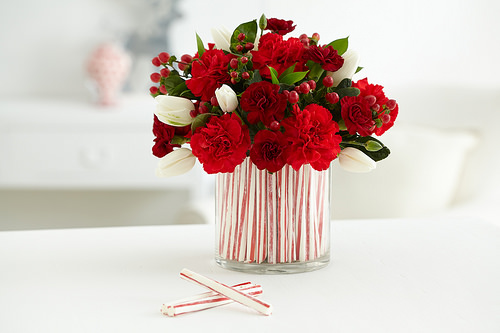

Image (CC 2.0)  by ProFlowers



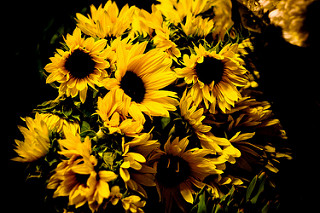

Image (CC 2.0)  by Michael Roper



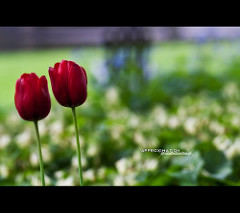

Image (CC 2.0)  by fRandi-Shooters



In [23]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print(caption_image(image_path))
    print()

### Determine the label for each image

- List the available labels:

In [25]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

- Assign an index to each label:

In [26]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

- Create a list of every file, and its label index

In [27]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                   for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [3, 4, 1, 2, 1, 4, 4, 0, 2, 4]


### Load and format the images

- TensorFlow includes all the tools you need to load and process images:

In [28]:
img_path = all_image_paths[0]
img_path

'C:\\Users\\SHIOKO\\.keras\\datasets\\flower_photos\\sunflowers\\164670176_9f5b9c7965.jpg'

- here is the raw data

In [29]:
img_raw = tf.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\...


- Decode it into an image tensor:

In [30]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(333, 500, 3)
<dtype: 'uint8'>


- Resize it for your model:

In [31]:
img_final = tf.image.resize_images(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
1.0


- Wrap up these in simple functions for later use.

In [39]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [192, 192])
    image /= 255.0 # normalize to [0, 1] range
    
    return image

In [33]:
def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

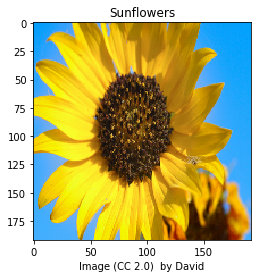

In [35]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())
plt.show()
# print()

## Build a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

### A dataset of images

- The easiest way to build a `tf.data.Dataset` is using the `from_tensor_slices` method.

- Slicing the array of strings results in dataset of strings:

In [36]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

- The `output_shapes` and `output_types` fields describe the content of each item in the dataset. In this case it is a set of scalar binary-strings

In [37]:
print('shape:', repr(path_ds.output_shapes))
print('type:', path_ds.output_types)
print()
print(path_ds)

shape: TensorShape([])
type: <dtype: 'string'>

<DatasetV1Adapter shapes: (), types: tf.string>


- Now create a new dataset that loads and formats images on the fly by mapping `preprocess_image` over the dataset of paths.

In [40]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

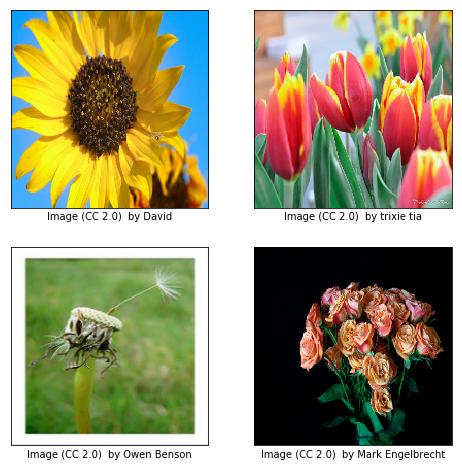

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
    plt.subplot(2, 2, n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(caption_image(all_image_paths[n]))

### A dataset of `(image, label)` pairs

- Using the same `from_tensor_slices` method we can build a dataset of labels

In [44]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [45]:
for label in label_ds.take(10):
    print(label_names[label.numpy()])

sunflowers
tulips
dandelion
roses
dandelion
tulips
tulips
daisy
roses
tulips


- Since the datasets are in the same order we can just zip them together to get a dataset of `(image, label)` pairs.

In [46]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

- The new dataset's `shapes` and `types` are tuples of shapes and types as well, describing each field:

In [47]:
print('image shape:', image_label_ds.output_shapes[0])
print('label shape:', image_label_ds.output_shapes[1])
print('types:', image_label_ds.output_types)
print()
print(image_label_ds)

image shape: (192, 192, 3)
label shape: ()
types: (tf.float32, tf.int64)

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


- **Note**: When you have arrays like `all_image_labels` and `all_image_paths` and alternative to `tf.data.dataset.Dataset.zip` is to slice the pair of arrays.

In [48]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

### Basic methods for training

- To train a model with this dataset you will want the data:

    - To be well shuffled.
    
    - To be batched.
    
    - To repeat forever.
    
    - Batches to be available as soon as possible.
    
- These features can be easily added using `tf.data` api.

In [49]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

- There are a few things to note here:

    1. The order is important.
    
        - A `.shuffle` after a `repeat` would shuffle items across epoch boundaries (some items will be seen twice before others are not seen at all).
        
        - A `.shuffle` after a `.batch` would shuffle the order of the batches, but not shuffle the items across batches.
        
    2. We use a `buffer_size` the same size as the dataset for a full shuffle. Up to the dataset size, large values provide better randomization, but use more memory.
    
    3. The shuffle buffer is filled before any elements are pulled from it. So a large `buffer_size` may cause a delay when your `Dataset` is starting.
    
    4. The shuffled dataset doesn't report the end of dataset until the shuffle-buffer is completely empty. The `Dataset` is restarted by `.repeat`, causing another wait for the shuffle-buffer to be filled.
    
- This last point can be addressed by using the [`tf.data.Dataset.apply`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#apply) method with the fused [`tf.data.experimental.shuffle_and_repeat`](https://www.tensorflow.org/api_docs/python/tf/data/experimental/shuffle_and_repeat) function:

In [50]:
ds = image_label_ds.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

### Pipe the dataset to a model

- Fetch a copy of MobileNet v2 from [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

- This will be used for a simple transfer learning example.

- Set the MobileNet weights to be non-trainable:

In [51]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable = False

9412608/9406464 [==============================] - 35s 4us/step


- This model expects its input to be normalized to the `[-1, 1]` range:

In [57]:
help(keras_applications.mobilenet_v2.preprocess_input)

NameError: name 'keras_applications' is not defined

- So before the passing it to the MobileNet model, we need to convert the input from a range of `[0, 1]` to `[-1, 1]`.

In [59]:
def change_range(image, label):
    return 2*image-1, label

keras_ds = ds.map(change_range)

- The MobileNet returns a `6x6` spatial grid of features for each image.

- Pass it a batch of images to see:

In [61]:
# The dataset may take a few seconds to start, as it fills its shuffle buffer.
image_batch, label_batch = next(iter(keras_ds))

In [62]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 6, 6, 1280)


- So build a model wrapped around MobileNet, and use `tf.keras.layers.GlobalAveragePooling2D` to average over those space dimensions, before the output `tf.keras.layers.Dense` layer:

In [63]:
model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(label_names))
])

- Now it produces outputs of the expected shape:

In [65]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print('max logit:', logit_batch.max())
print()

print('Shape:', logit_batch.shape)

min logit: -2.2535176
max logit: 2.2628586

Shape: (32, 5)


- Compile the model to describe the training procedure:

In [66]:
model.compile(optimizer=tf.train.AdamOptimizer(),
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=['accuracy'])

There are 2 trainable variables: The Dense `weights` and `bias`:

In [67]:
len(model.trainable_variables)

2

In [68]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


- Train the model.

- Normally you would specify the read number of steps per epoch, but for demonstration purposes only run 3 steps.

In [69]:
steps_per_epoch = tf.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

115.0

In [74]:
model.fit(keras_ds, epochs=1, steps_per_epoch=3)

3/3 [==============================] - 11s 4s/step - loss: 1.6094 - acc: 0.2188
